## more methods

The previous method failed, can we try something else like
https://github.com/pupil-labs/pupil/blob/master/pupil_src/capture/pupil_detectors/canny_detector.py

or detect all contours, then apply a heuristic to catch the features (in previosion to use camshift to track them)...


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.set_printoptions(precision=2, suppress=True)
# define plots to be inserted interactively
%matplotlib inline
import matplotlib.pyplot as plt
#import cv2

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


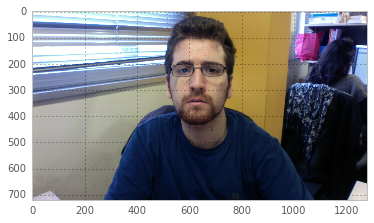

In [2]:
from openRetina import PhotoReceptor
cam = PhotoReceptor()
frame = cam.grab()
frame = cam.grab()
cam.close()
plt.imshow(frame)

if len(cam.ctime) >0:
    plt.plot(np.diff(np.array(cam.ctime))*1000, '+')
    _ = plt.axis('tight')
    print ('FPS : ',  cam.N/(cam.ctime[-1]-cam.ctime[0]))

### Using 42 frames recorded with 2015-11-05 notebook



In [4]:
import cv2
import os

N_frame = 42

folder = '/tmp/debug'
img0 = cv2.imread(os.path.join(folder, 'frame_1.png'))
H, W, three = img0.shape

movie = np.zeros((H, W, 3, N_frame), dtype=np.uint8)

for i in range(N_frame):
    fname = 'frame_{i}.png'.format(i=i)
    movie[:, :, :, i] = cv2.imread(os.path.join(folder, fname))


(720, 1280, 3, 42) 0 255


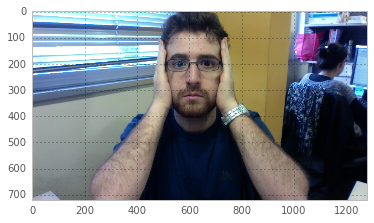

In [5]:
print(movie.shape, movie.min(), movie.max())
plt.imshow(img0)

2
2
73 78 68 68
2
72 80 65 65


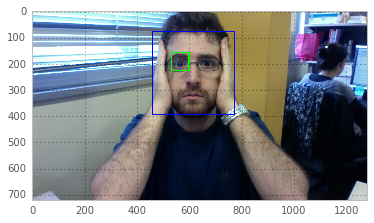

In [6]:
import cv2

face_cascade = cv2.CascadeClassifier('/usr/local/Cellar/opencv3/3.1.0_1/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/usr/local/Cellar/opencv3/3.1.0_1/share/OpenCV/haarcascades/haarcascade_eye.xml')
lefteye_cascade = cv2.CascadeClassifier('/usr/local/Cellar/opencv3/3.1.0_1/share/OpenCV/haarcascades/haarcascade_lefteye_2splits.xml')
righteye_cascade = cv2.CascadeClassifier('/usr/local/Cellar/opencv3/3.1.0_1/share/OpenCV/haarcascades/haarcascade_righteye_2splits.xml')

img_ = img0.copy()
img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2BGR)

out = img0.copy()
def get_just_one(image, cascade):
    # We set set minNeighbors=1 then increase it until we have one face only - same for eyes see http://stackoverflow.com/questions/22249579/opencv-detectmultiscale-minneighbors-parameter
    features, minNeighbors = [], 1
    while len(features) == 0 and minNeighbors<200:
        features = cascade.detectMultiScale(image, 1.1, minNeighbors) # image[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize]
        minNeighbors += 1
        print(minNeighbors)
    return features[0], minNeighbors

(x,y,w,h), minNeighbors = get_just_one(img_, face_cascade)

img_ = cv2.rectangle(img_, (x,y), (x+w,y+h), (255,0,0), 2)
roi_color = img_[y:y+h, x:x+w]
out_color = out[y:y+h, x:x+w]

(lex, ley, lew, leh), minNeighbors = get_just_one(roi_color, lefteye_cascade)
cv2.rectangle(roi_color, (lex, ley), (lex+lew, ley+leh), (0,255,0), 2)
left_eye = out_color[ley:ley+leh, lex:lex+lew]
print(lex, ley, lew, leh)

(rex, rey, rew, reh), minNeighbors = get_just_one(roi_color, righteye_cascade)
cv2.rectangle(roi_color, (rex, rey), (rex+rew, rey+reh), (0,255,0), 2)
right_eye = out_color[rey:rey+reh, rex:rex+rew]
print(rex, rey, rew, reh)

plt.imshow(cv2.cvtColor(img_, cv2.COLOR_BGR2RGB))
#plt.imshow(cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB))

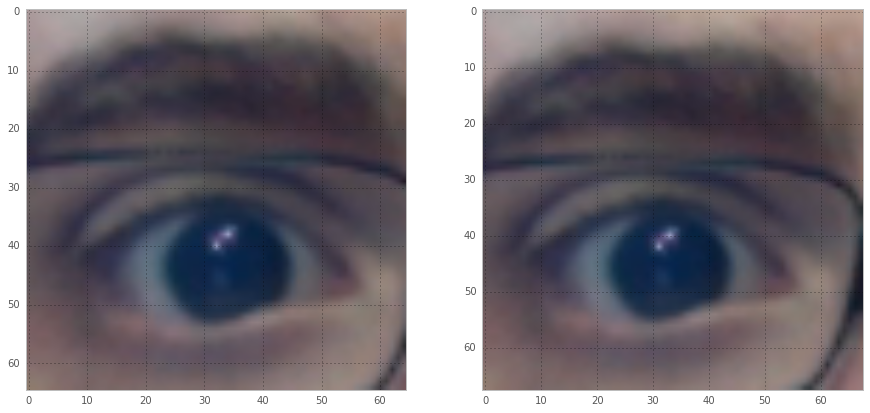

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
for i, eye in enumerate([right_eye, left_eye]):
    axs[i].imshow(eye)


##  segmenting using dynamics

- the eyebrow on upper quarter 
- the skin is all around
- the reflection is white and small
- the iris is round, darker


In [8]:
flags = [i for i in dir(cv2) if i.startswith('COLOR_')]
#print (flags)

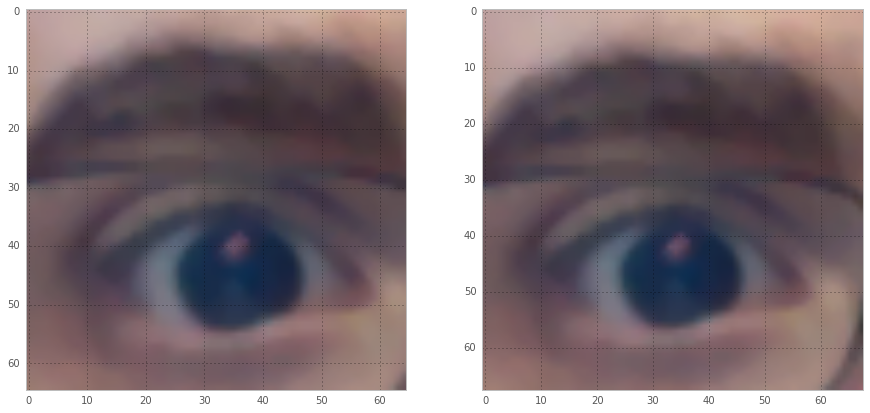

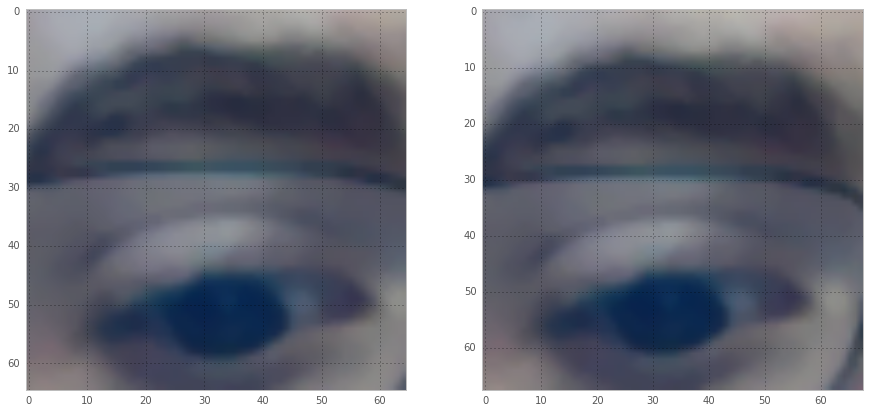

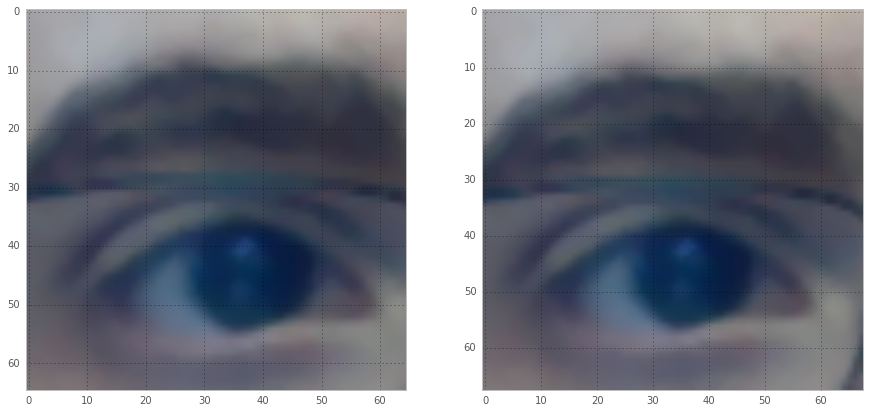

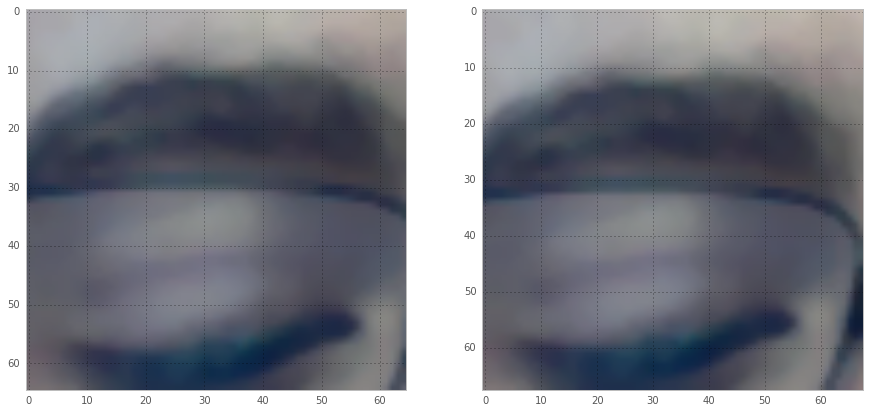

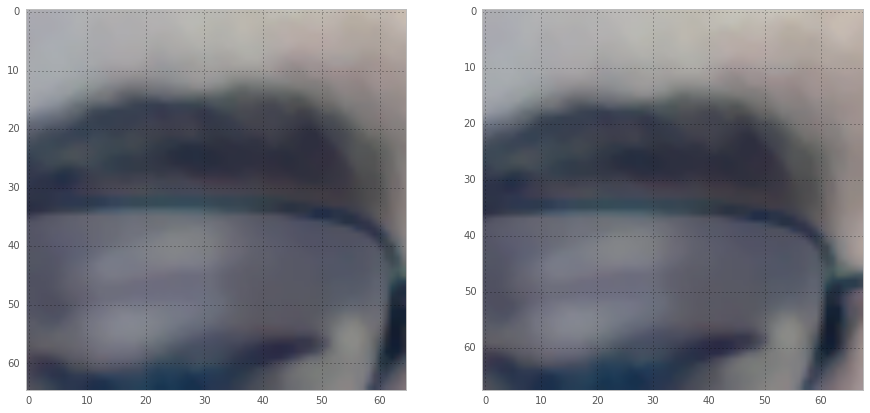

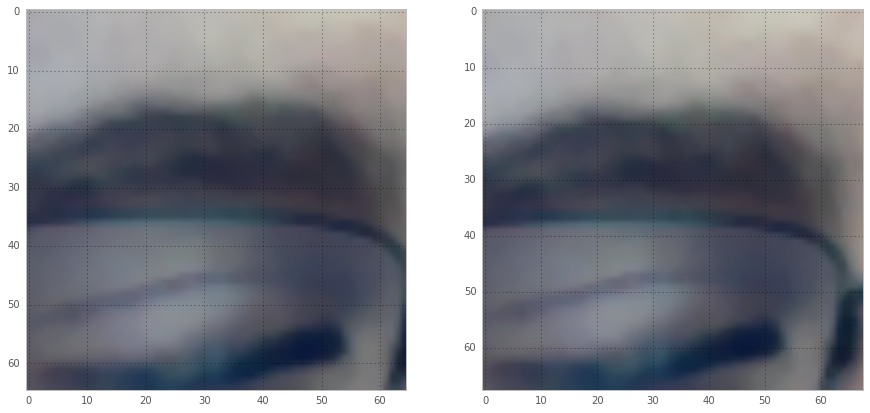

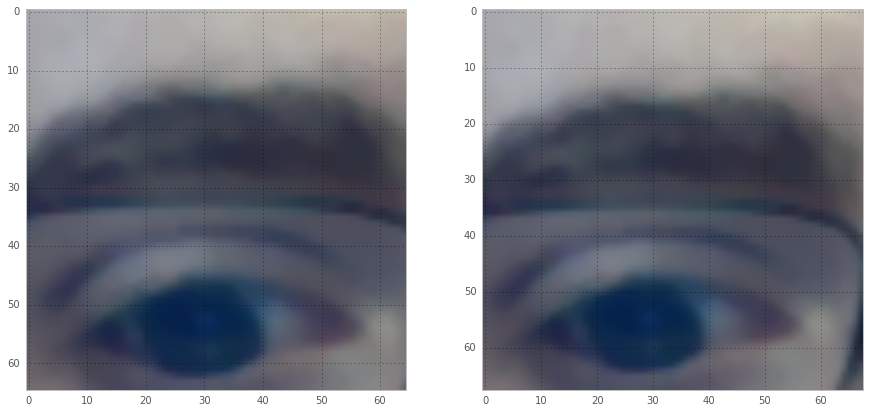

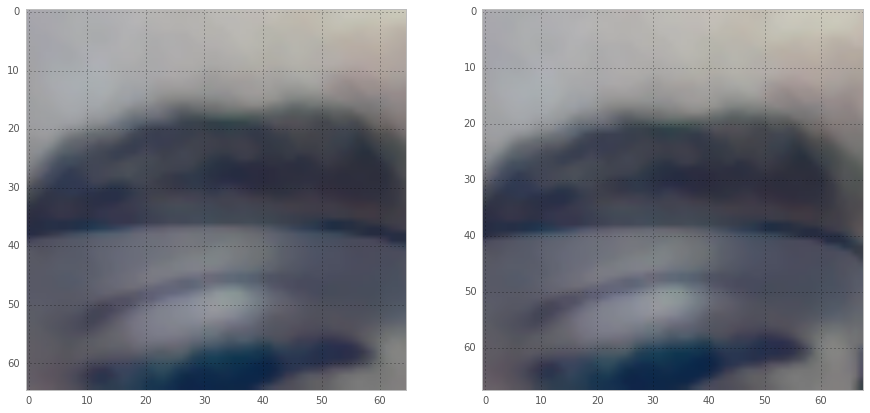

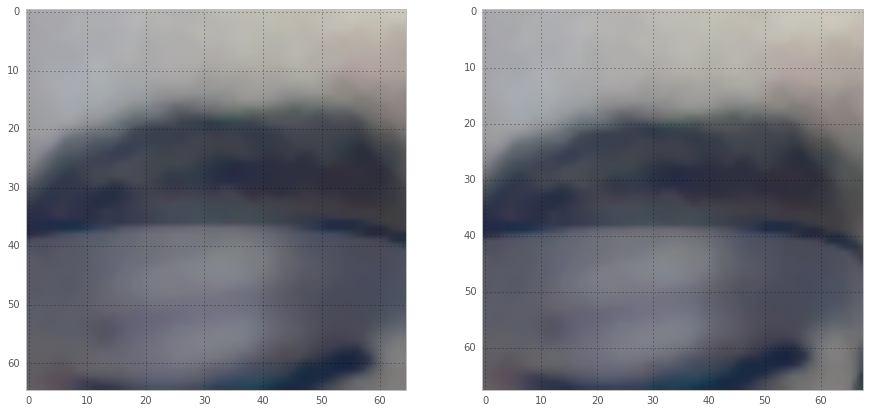

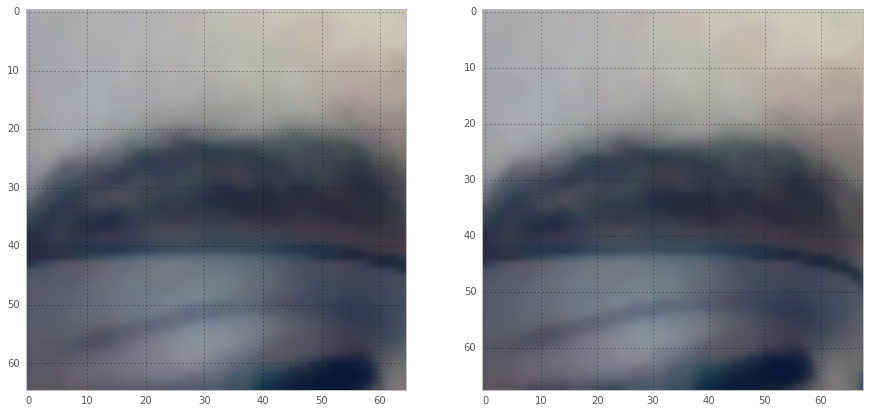

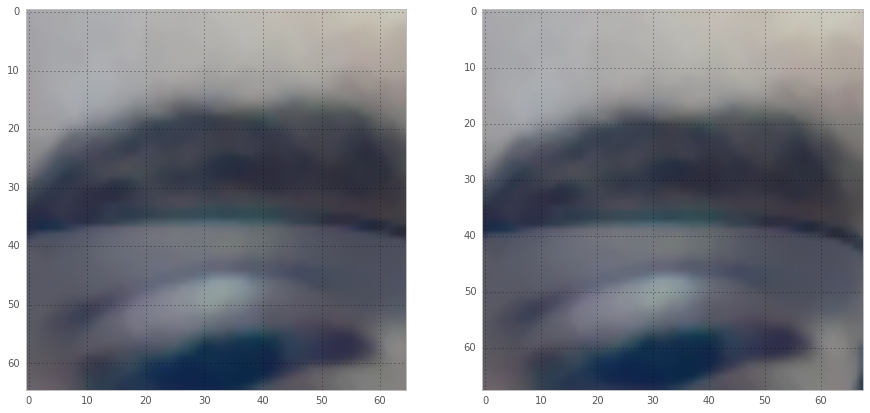

In [9]:
left_eye_movie = np.zeros((leh, lew, 3, N_frame), dtype=np.uint8)
right_eye_movie = np.zeros((reh, rew, 3, N_frame), dtype=np.uint8)
for i in range(N_frame):
    out_color = movie[y:y+h, x:x+w, :, i]
    out_color = cv2.medianBlur(out_color, 3)
    #out_color = cv2.cvtColor(out_color, cv2.COLOR_BGR2HSV)
    left_eye_movie[:, :, :, i] = out_color[ley:ley+leh, lex:lex+lew]
    right_eye_movie[:, :, :, i] = out_color[rey:rey+reh, rex:rex+rew]
    if i % 4 ==0:
        fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
        for i_, eye in enumerate([right_eye_movie[:, :, :, i], left_eye_movie[:, :, :, i]]):
            axs[i_].imshow(eye)

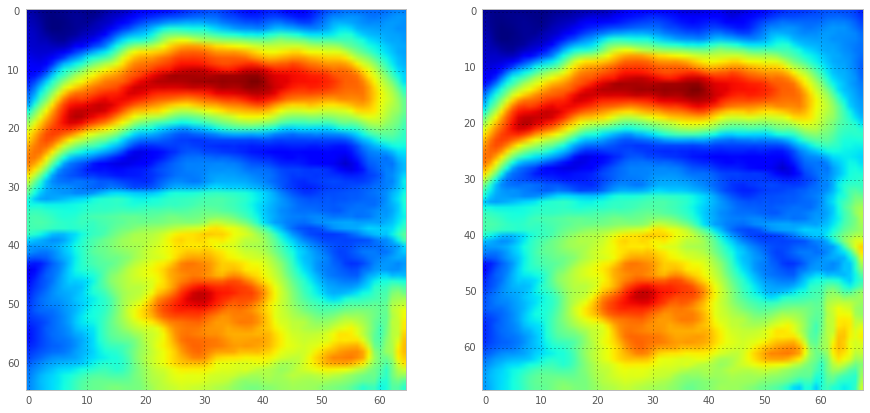

In [10]:
# deviation in the average (gray image)
std_left_eye = left_eye_movie.mean(axis=-2).std(axis=-1)
std_right_eye = right_eye_movie.mean(axis=-2).std(axis=-1)

fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
for i, eye in enumerate([std_right_eye, std_left_eye]):
    axs[i].imshow(eye)

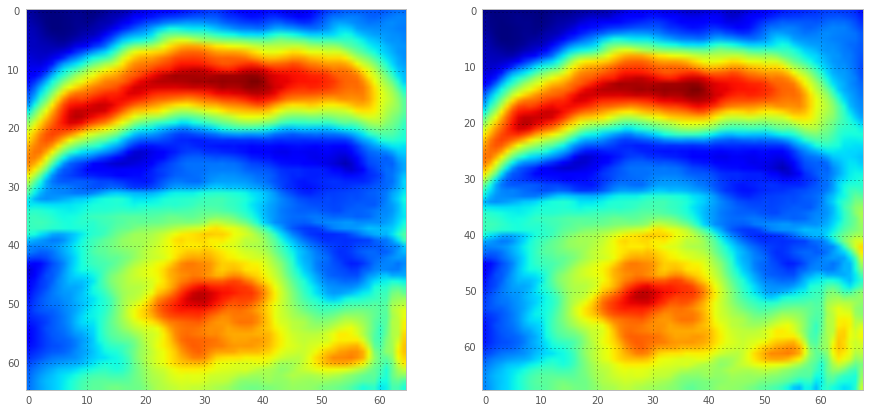

In [11]:
# better : average of the deviation in each channel
std_left_eye = left_eye_movie.std(axis=-1).mean(axis=-1)
std_right_eye = right_eye_movie.std(axis=-1).mean(axis=-1)

fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
for i, eye in enumerate([std_right_eye, std_left_eye]):
    axs[i].imshow(eye)

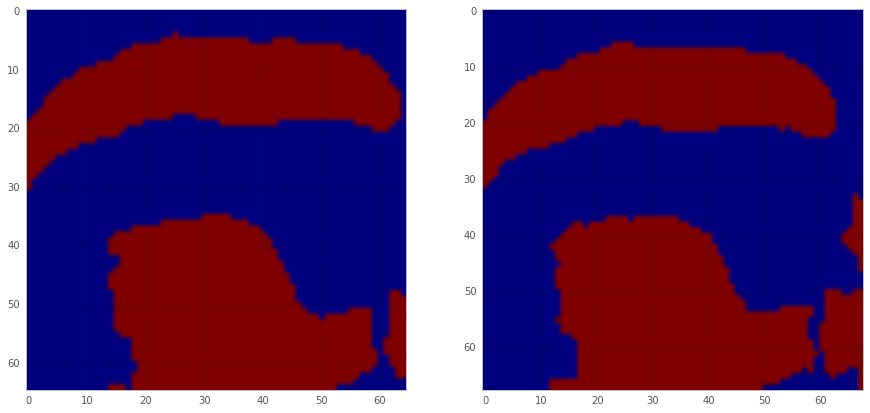

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
for i, eye in enumerate([std_right_eye, std_left_eye]):
    eye /= eye.max()
    eye *= 255
    ret_skin, skin_mask = cv2.threshold(eye.astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    axs[i].imshow(skin_mask)

Final touch: erode and dilate until we only one connected component, see https://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html

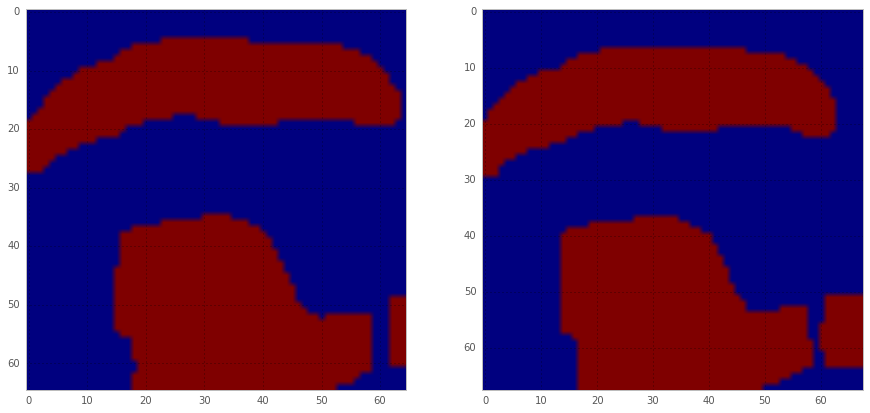

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
for i, eye in enumerate([std_right_eye, std_left_eye]):
    eye /= eye.max()
    eye *= 255
    ret_skin, skin_mask = cv2.threshold(eye.astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((5, 5))
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel)    
    axs[i].imshow(skin_mask)


### histogram backprojection

Now that we have a nice mask, we may grab (only) the interesting part: the eye and pupil... We will use the method described in https://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_backprojection/py_histogram_backprojection.html



In [14]:
left_eye_movie = np.zeros((leh, lew, 3, N_frame), dtype=np.uint8)
right_eye_movie = np.zeros((reh, rew, 3, N_frame), dtype=np.uint8)
for i in range(N_frame):
    out_color = movie[y:y+h, x:x+w, :, i]
    #out_color = cv2.medianBlur(out_color, 7)
    #out_color = cv2.cvtColor(out_color, cv2.COLOR_BGR2HSV)
    left_eye_movie[:, :, :, i] = out_color[ley:ley+leh, lex:lex+lew]
    right_eye_movie[:, :, :, i] = out_color[rey:rey+reh, rex:rex+rew]


0.0 255.0 <class 'numpy.ndarray'>
0 255 <class 'numpy.ndarray'>
0 255 (65, 65, 3) <class 'numpy.ndarray'>
10.0 212.0 (65, 65, 3) <class 'numpy.ndarray'>
0.0 255.0 <class 'numpy.ndarray'>
0 255 <class 'numpy.ndarray'>
0 255 (68, 68, 3) <class 'numpy.ndarray'>
10.0 218.0 (68, 68, 3) <class 'numpy.ndarray'>


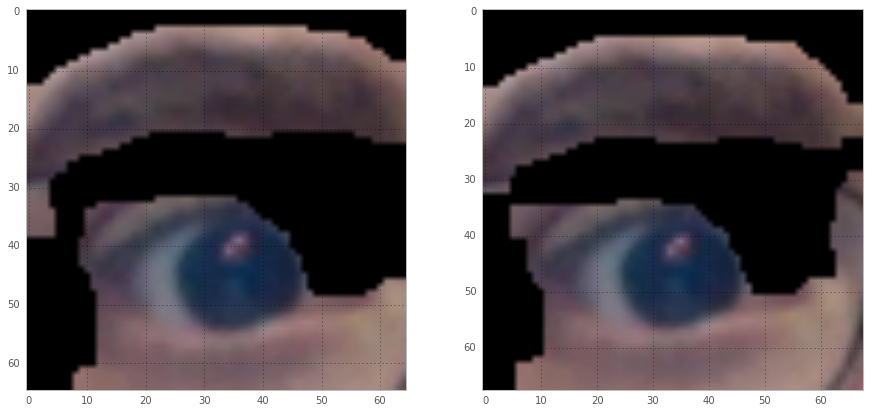

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
for i, eye_movie in enumerate([right_eye_movie, left_eye_movie]):
    #print(eye_movie.min(), eye_movie.max(), type(eye_movie))
    eye_movie = eye_movie.astype(np.float)
    std_eye = eye_movie.std(axis=-1).mean(axis=-1)
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    std_eye /= std_eye.max()
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    std_eye *= 255
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    std_eye = std_eye.astype(np.uint8)
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    ret_skin, skin_mask = cv2.threshold(std_eye, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((5, 5))
    for ii_ in range(3):
        skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel)    
        skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel)   
    #print(skin_mask.min(), skin_mask.max(), type(skin_mask))

    # calculating object histogram
    roihist = cv2.calcHist([std_eye], [0], skin_mask, [256], [0,256])
    #print(roihist.min(), roihist.max(), type(roihist))

    # normalize histogram and apply backprojection
    cv2.normalize(roihist, roihist, 0, 255, cv2.NORM_MINMAX)
    print(roihist.min(), roihist.max(), type(roihist))
    skin_mask = cv2.calcBackProject([std_eye], [0,1], roihist, [0, 256], 1)
    print(skin_mask.min(), skin_mask.max(), type(skin_mask))

    # Now convolute with circular disc
    disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    cv2.filter2D(skin_mask, -1, disc, skin_mask)
    for ii_ in range(3):
        skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel)    
        skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel)   

    # threshold and binary AND
    ret, skin_mask = cv2.threshold(skin_mask, 50, 255, 0)
    skin_mask = cv2.merge((skin_mask,skin_mask,skin_mask))
    print(skin_mask.min(), skin_mask.max(), skin_mask.shape, type(skin_mask))
    print(eye_movie[:, :, :, 0].min(), eye_movie[:, :, :, 0].max(), eye_movie[:, :, :, 0].shape, type(eye_movie[:, :, :, 0]))
    eye = cv2.bitwise_and(eye_movie[:, :, :, 0].astype(np.uint8), skin_mask)

    axs[i].imshow(eye)
    

A simpler method:

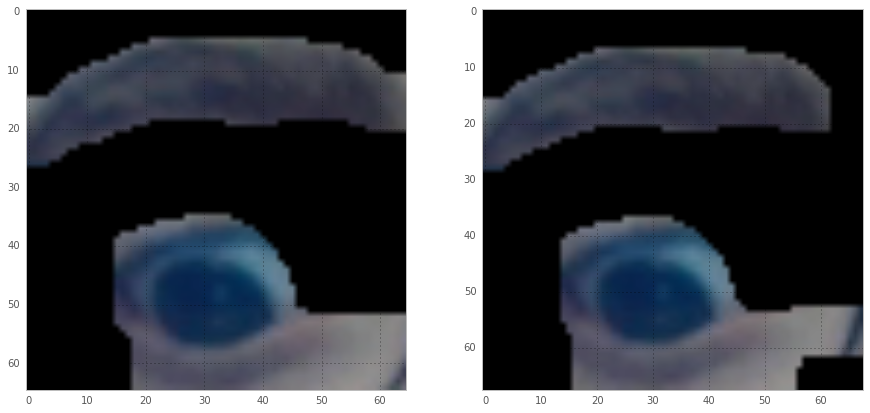

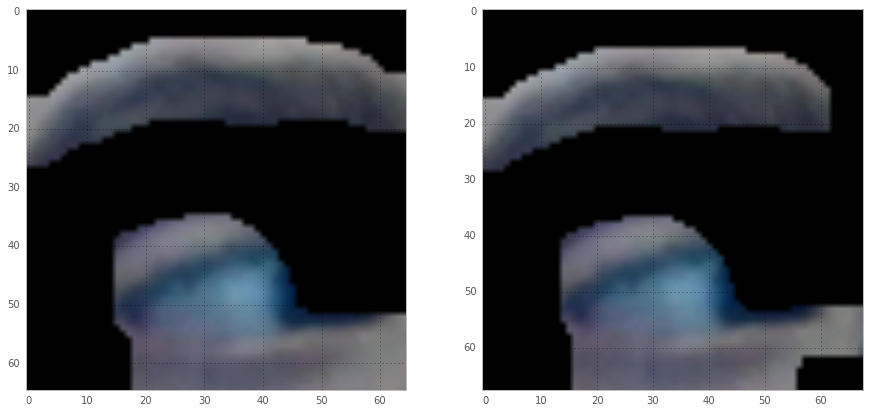

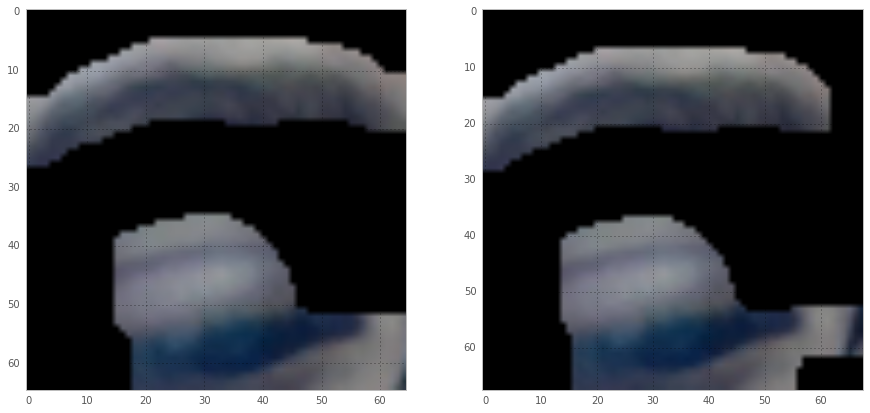

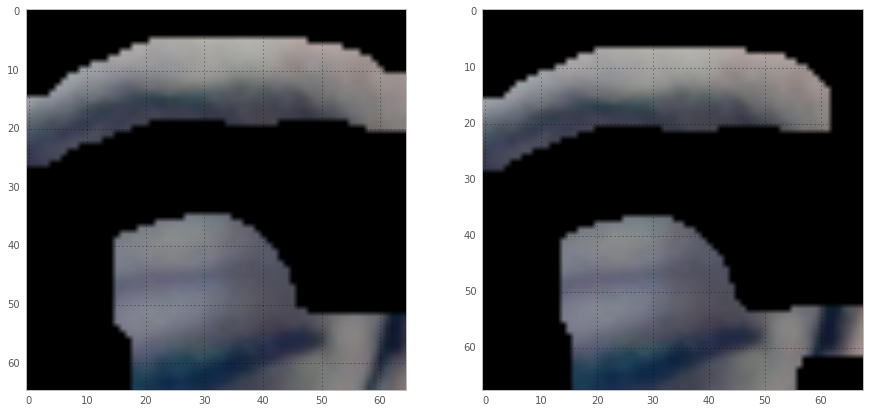

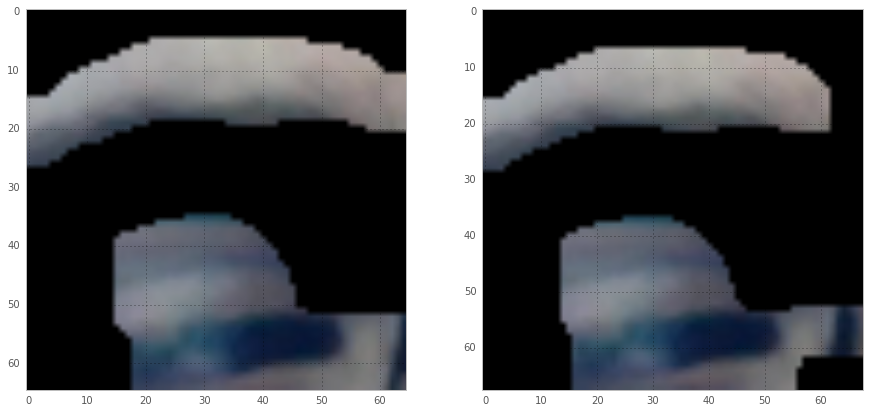

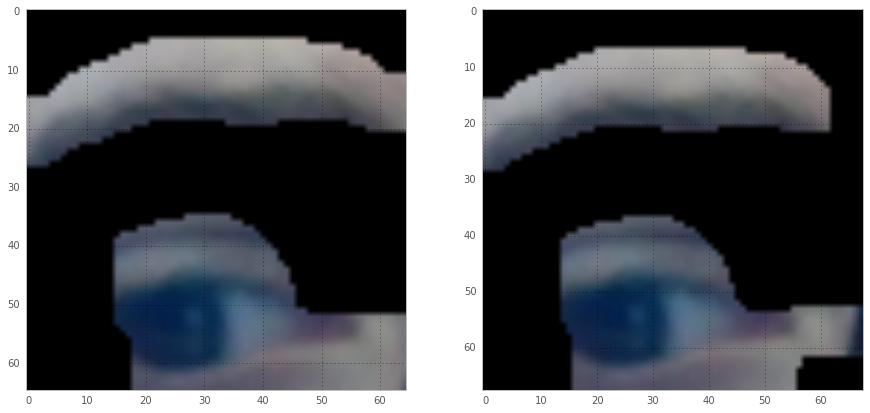

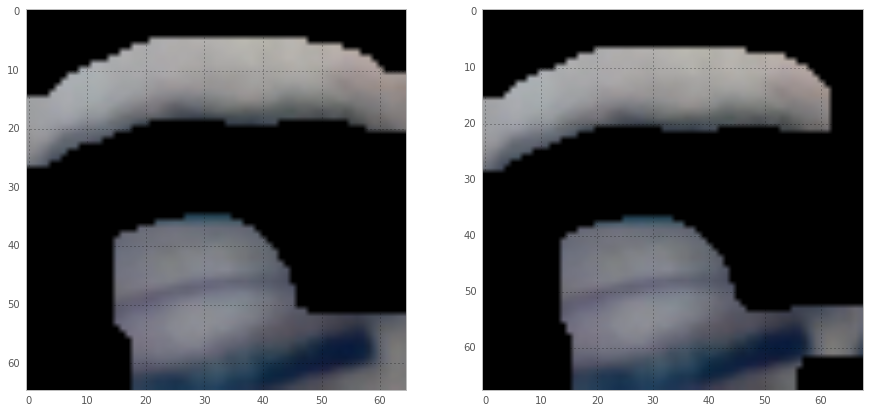

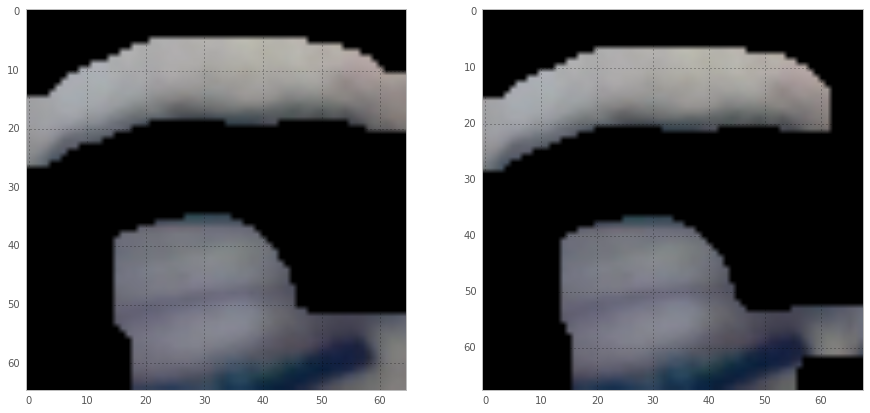

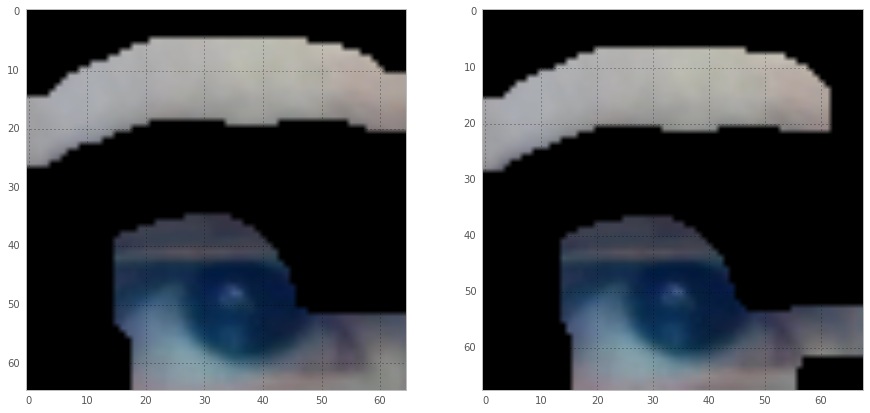

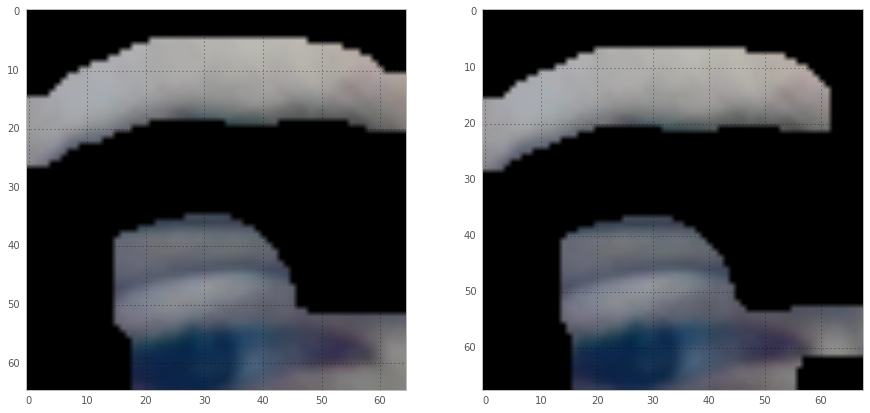

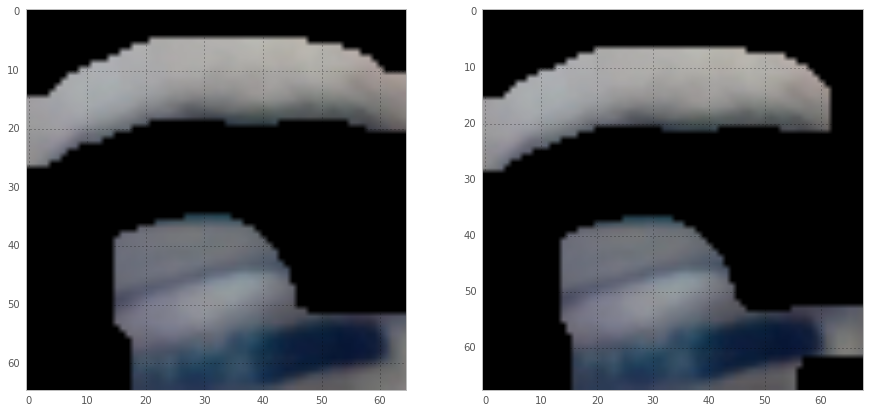

In [16]:
masks = []

for i, eye_movie in enumerate([right_eye_movie, left_eye_movie]):
    eye_movie_b = np.zeros_like(eye_movie)
    for i in range(N_frame):
        eye_movie_b[:, :, :, i] = cv2.medianBlur(eye_movie[:, :, :, i], 7)

    #print(eye_movie.min(), eye_movie.max(), type(eye_movie))
    eye_movie_b = eye_movie_b.astype(np.float)
    std_eye = eye_movie_b.std(axis=-1).mean(axis=-1)
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    std_eye /= std_eye.max()
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    std_eye *= 255
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    std_eye = std_eye.astype(np.uint8)
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    ret_skin, skin_mask = cv2.threshold(std_eye, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((7, 7))
    for ii_ in range(3):
        skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel)   
        skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel)    
    #print(skin_mask.min(), skin_mask.max(), type(skin_mask))

    # threshold and binary AND
    skin_mask = cv2.merge((skin_mask,skin_mask,skin_mask))
    #print(skin_mask.min(), skin_mask.max(), skin_mask.shape, type(skin_mask))
    masks.append(skin_mask)

for i_t in range(N_frame):
    if i_t % 4 ==0: fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
    for i, (eye_movie, skin_mask) in enumerate(zip([right_eye_movie, left_eye_movie], masks)):
        eye = cv2.bitwise_and(eye_movie[:, :, :, i_t].astype(np.uint8), skin_mask)
        if i_t % 4 ==0: axs[i].imshow(eye)
        axs[i].imshow(eye)

## more methods?

idea: detect all contours, then apply a heuristic to catch the features

In [17]:
image, contours, hierarchy = cv2.findContours(skin_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
M = cv2.moments(cnt)
print (M)
skin_mask = cv2.drawContours(skin_mask, contours, -1, (0,255,0), 3)
plt.imshow(skin_mask)


error: /tmp/opencv320160115-4309-1uueyhw/opencv-3.1.0/modules/imgproc/src/contours.cpp:198: error: (-210) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function cvStartFindContours


In [ ]:
ellipse = cv2.fitEllipse(cnt)
skin_mask = cv2.ellipse(skin_mask, ellipse,(0,255,0), 2)
(x,y),(MA,ma),angle = cv2.fitEllipse(cnt)
print((x,y),(MA,ma),angle)

In [ ]:
img = eyelist[0].copy()
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
fig = plt.figure(figsize=(15, 5))
for i in range (3): 
    ax = fig.add_subplot(1, 3, i+1)
    plt.imshow(hsv[:, :, i]*skin_mask)


In [ ]:
value = hsv[:, :, 2].copy()
hist = cv2.calcHist([value], [0], skin_mask * (255 - reflection_mask), [256], [0, 256])
ret, iris_mask = cv2.threshold(value, otsu_thresh(hist), 255, cv2.THRESH_BINARY)
iris_mask = cv2.bitwise_and(iris_mask, iris_mask, mask=skin_mask * (255 - reflection_mask))
plt.imshow(iris_mask)

In [ ]:
iris = iris_mask + skin_mask
iris = cv2.erode(iris, kernel, iterations = 1)
plt.imshow(iris)
plt.colorbar()

In [ ]:
image, contours, hierarchy = cv2.findContours(skin_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
M = cv2.moments(cnt)
(x,y),(MA,ma),angle = cv2.fitEllipse(cnt)
print((x,y),(MA,ma),angle)

## more methods : use canny

https://github.com/pupil-labs/pupil/blob/master/pupil_src/capture/pupil_detectors/canny_detector.py


In [ ]:
image = right_eye.copy()

#ret,thresh = cv2.threshold(img,127,255,0)
edges = cv2.Canny(image, 50, 120)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(edges)

In [ ]:
image_, contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    rect = cv2.boundingRect(cnt)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt,True)
    if area > 0:
        print (perimeter, area, perimeter**2/area)
    #M = cv2.moments(cnt)
    #print (M)
edges = cv2.drawContours(edges, contours, -1, (0,255,0), 3)
plt.imshow(edges)

In [ ]:
image = eyelist[0].copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY, cv2.CV_64F)*1.
image - image.mean()
image /= (image.max() - image.min())
print(image.max(), image.min())
#image = cv2.equalizeHist(image)
kernel = np.ones((3,3))/5
N = image.shape[0]//8
min_DOG, max_DOG = np.zeros(N), np.zeros(N)
for i in range(N):
    #
    image = cv2.filter2D(image, -1, kernel)
    DOG = cv2.Laplacian(image, cv2.CV_64F)#, None, 2*i+1)
    min_DOG[i], max_DOG[i] = DOG.min(), DOG.max()

fig = plt.figure(figsize=(15, 5))

for i, _DOG in enumerate([min_DOG, max_DOG]): 
    ax = fig.add_subplot(1, 2, i+1)
    ax.plot(range(N), _DOG)

In [ ]:
cv2.SimpleBlobDetector?

In [ ]:
cv2.SimpleBlobDetector_create?